# Recommendation Engine with Graphs

In this project, We applied a graph-based recommendation engine to Disney+dataset.By Connecting movies and TV Shows through shared attributes, we used the Adamic Adar measure to generate personalized content recommendations.

- Dataset Link: [https://www.kaggle.com/datasets/shivamb/disney-movies-and-tv-shows]


## Brief Summary of the Approach:
We connect different TV shows/movies on Disney+ using a graph where each node represents a movie or a TV show. From the graph, we measure the Adamic Adar Measure: the higher this score for a node pair, the closer the nodes are. The measures between all movies are NOT pre-calculated; to determine the list of recommendation films, we explore the neighborhood of the target film.

To take into account the description, we calculate the TF-IDF matrix and for each film, take the top 5 similar descriptions and create a node Similar_to_this. This node is included in the Adamic Adar measure.

### In the Graph:
Nodes: Movies, Person (actor or director), Categories, Countries, Cluster (description), Sim(title)—top 5 similar movies in the sense of the description.

Edges:

ACTED_IN: relation between an actor and a movie

CAT_IN: relation between a category and a movie

DIRECTED: relation between a director and a movie

COU_IN: relation between a country and a movie

DESCRIPTION: relation between a cluster and a movie

SIMILARITY: relation in the sense of the description, so two movies are not directly connected, but they share persons, categories, clusters, and countries.

#### Generating Recommendations:
To generate the recommendations, we explore the neighborhood of the target film, which includes actors, directors, countries, and categories. We then explore the neighborhood of each neighbor to discover the movies that share a node with the target film. Finally, we calculate the Adamic Adar measure to provide the final results.

# Importing the dependencies

In [1]:
import pandas as pd 
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np 
import math  
import time 
import seaborn as sns

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [14, 14]

# Loading the Dataset 

In [3]:
df = pd.read_csv(r"E:\Projects\Recommendation engine Using networkx\disney_plus_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",NaN,"November 26, 2021",2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",NaN,"November 26, 2021",1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,"November 26, 2021",2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",NaN,"November 26, 2021",2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!"
4,s5,TV Show,The Beatles: Get Back,NaN,"John Lennon, Paul McCartney, George Harrison, ...",NaN,"November 25, 2021",2021,NaN,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...


In [4]:
df.shape

(1450, 12)

In [5]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [6]:
df['date_added'] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

df['directors'] = df['director'].apply(lambda l: \
        ([] if pd.isna(l) else [i.strip() for i in l.split(',')]))
df['categories'] = df['listed_in'].apply(lambda l: \
        ([] if pd.isna(l) else [i.strip() for i in l.split(',')]))
df['actors'] = df['cast'].apply(lambda l: \
                                ([] if pd.isna(l) else [i.strip()
                                for i in l.split(',')]))
df['countries'] = df['country'].apply(lambda l: \
        ([] if pd.isna(l) else [i.strip() for i in l.split(',')]))

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",NaN,2021-11-26,2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!,2021.0,11.0,26.0,"[Alonso Ramirez Ramos, Dave Wasson]","[Animation, Family]","[Chris Diamantopoulos, Tony Anselmo, Tress Mac...",[]
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",NaN,2021-11-26,1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...,2021.0,11.0,26.0,[John Cherry],[Comedy],"[Jim Varney, Noelle Parker, Douglas Seale]",[]
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,2021-11-26,2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.,2021.0,11.0,26.0,[Karen Disher],"[Animation, Comedy, Family]","[Raymond Albert Romano, John Leguizamo, Denis ...",[United States]
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",NaN,2021-11-26,2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!",2021.0,11.0,26.0,[Hamish Hamilton],[Musical],"[Darren Criss, Adam Lambert, Derek Hough, Alex...",[]
4,s5,TV Show,The Beatles: Get Back,NaN,"John Lennon, Paul McCartney, George Harrison, ...",NaN,2021-11-25,2021,NaN,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...,2021.0,11.0,25.0,[],"[Docuseries, Historical, Music]","[John Lennon, Paul McCartney, George Harrison,...",[]


In the next step, we will build the tfidf matrix with the descriptions and find similar - get the top_n movies with description similar to the target description.
- This is followed by creation of Graph using the approach described above.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(
    max_df=0.4,
    min_df=1,
    stop_words='english',
    lowercase=True,
    use_idf=True,
    norm=u'l2',
    smooth_idf=True,
    )
tfidf = vector.fit_transform(text_content)

def find_similar(tfidf_matrix, index, top_n=5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index + 1],
            tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::
                            -1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

# Create Graph using networkx 

In [8]:
G = nx.Graph(label='MOVIE')
start_time = time.time()
for (i, rowi) in df.iterrows():
    G.add_node(rowi['title'], key=rowi['show_id'], label='MOVIE',
               mtype=rowi['type'], rating=rowi['rating'])
    for element in rowi['actors']:
        G.add_node(element, label='PERSON')
        G.add_edge(rowi['title'], element, label='ACTED_IN')
    for element in rowi['categories']:
        G.add_node(element, label='CAT')
        G.add_edge(rowi['title'], element, label='CAT_IN')
    for element in rowi['directors']:
        G.add_node(element, label='PERSON')
        G.add_edge(rowi['title'], element, label='DIRECTED')
    for element in rowi['countries']:
        G.add_node(element, label='COU')
        G.add_edge(rowi['title'], element, label='COU_IN')

    indices = find_similar(tfidf, i, top_n=5)
    snode = 'Sim(' + (rowi['title'])[:15].strip() + ')'
    G.add_node(snode, label='SIMILAR')
    G.add_edge(rowi['title'], snode, label='SIMILARITY')
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label='SIMILARITY')


def get_all_adj_nodes(list_in):
    sub_graph = set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
            sub_graph.add(e)
    return list(sub_graph)


def draw_sub_graph(sub_graph, size='s'):
    subgraph = G.subgraph(sub_graph)
    colors = []
    for e in subgraph.nodes():
        if G.nodes[e]['label'] == 'MOVIE':
            colors.append('#96cdeb')
        elif G.nodes[e]['label'] == 'PERSON':
            colors.append('#ed859d')
        elif G.nodes[e]['label'] == 'CAT':
            colors.append('#9ce087')
        elif G.nodes[e]['label'] == 'COU':
            colors.append('#edf283')
        elif G.nodes[e]['label'] == 'SIMILAR':
            colors.append('#edb672')
        elif G.nodes[e]['label'] == 'CLUSTER':
            colors.append('#edb672')

    if size == 's':
        plt.figure(figsize=(8, 8))
    else:
        plt.figure(figsize=(15, 15))
    nx.draw(subgraph, with_labels=True, font_size=12,
            node_color=colors, edge_color='#c4c2be')
    plt.show()


def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2 == root:
                continue
            if G.nodes[e2]['label'] == 'MOVIE':
                commons = commons_dict.get(e2)
                if commons == None:
                    commons_dict.update({e2: [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2: commons})
    movies = []
    weight = []
    for (key, values) in commons_dict.items():
        w = 0.0
        for e in values:
            w = w + 1 / math.log(G.degree(e))
        movies.append(key)
        weight.append(w)

    result = pd.Series(data=np.array(weight), index=movies)
    result.sort_values(inplace=True, ascending=False)
    return result

def recommend(input_movie):
    print("*"*40+"\n\n Movie: "+input_movie+"\n\n"+"*"*40)

    list_in = [input_movie]
    sub_graph = get_all_adj_nodes(list_in)
    draw_sub_graph(sub_graph)

    result = get_recommendation(input_movie)
    print(result.head())

    print ("\n")
    print("*"*100+"\n\n Extended Recommendation with Attributes")
    # print ("\n")
    print("*"*100)

    reco=list(result.index[:4].values)
    reco.extend([input_movie])
    sub_graph = get_all_adj_nodes(reco)
    draw_sub_graph(sub_graph, size='w')

****************************************

 Movie: Marvel Studios' Iron Man 2

****************************************


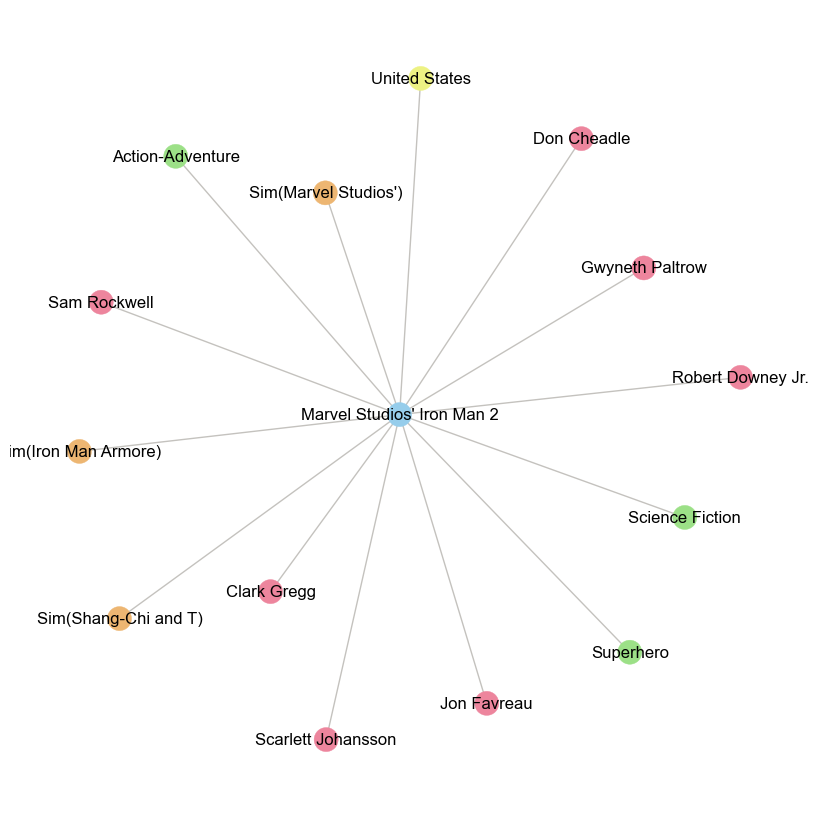

Marvel Studios' Iron Man                      3.577299
Marvel Studios' Iron Man 3                    3.182425
Marvel Studios: Assembling A Universe         2.797501
Marvel Studios' Captain America: Civil War    2.706480
Marvel Studios' Avengers: Infinity War        2.366857
dtype: float64


****************************************************************************************************

 Extended Recommendation with Attributes
****************************************************************************************************


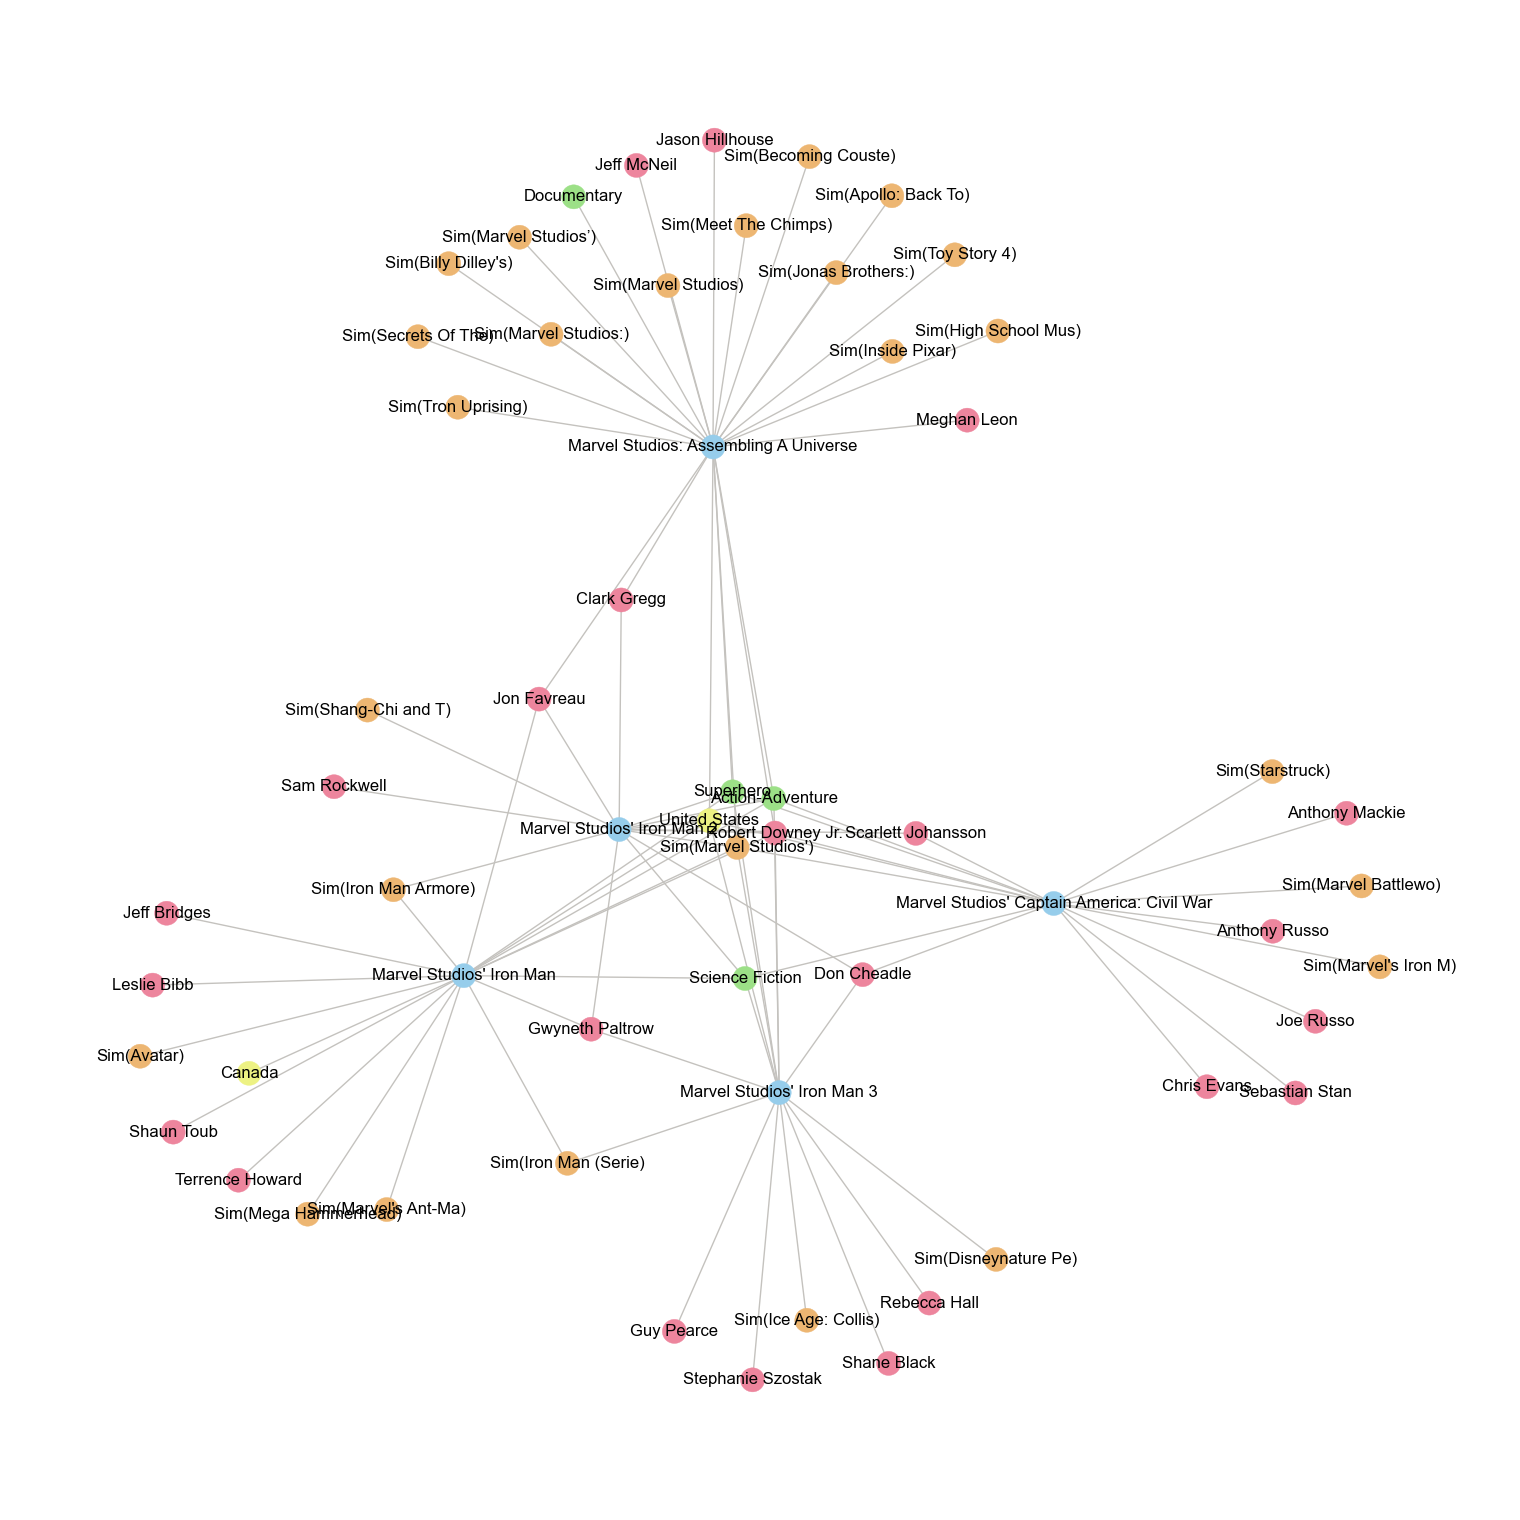

In [9]:
recommend("Marvel Studios' Iron Man 2")

****************************************

 Movie: X-Men Origins: Wolverine

****************************************


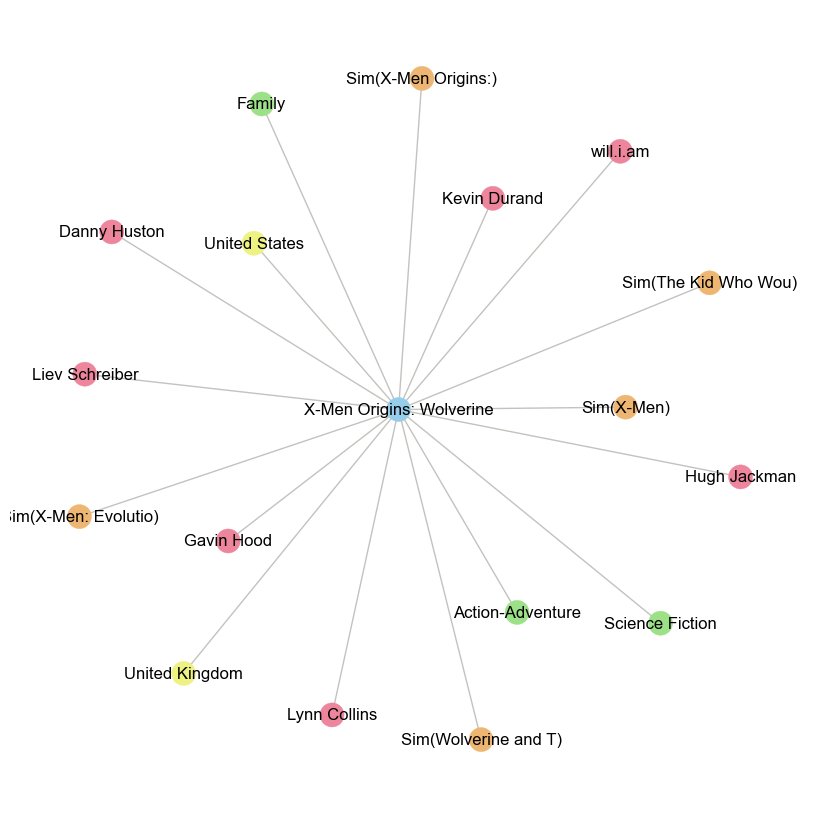

X-Men: First Class            2.975686
X-Men                         2.914072
X-Men: Days of Future Past    2.014530
X-Men: Evolution              1.979209
John Carter                   1.902638
dtype: float64


****************************************************************************************************

 Extended Recommendation with Attributes
****************************************************************************************************


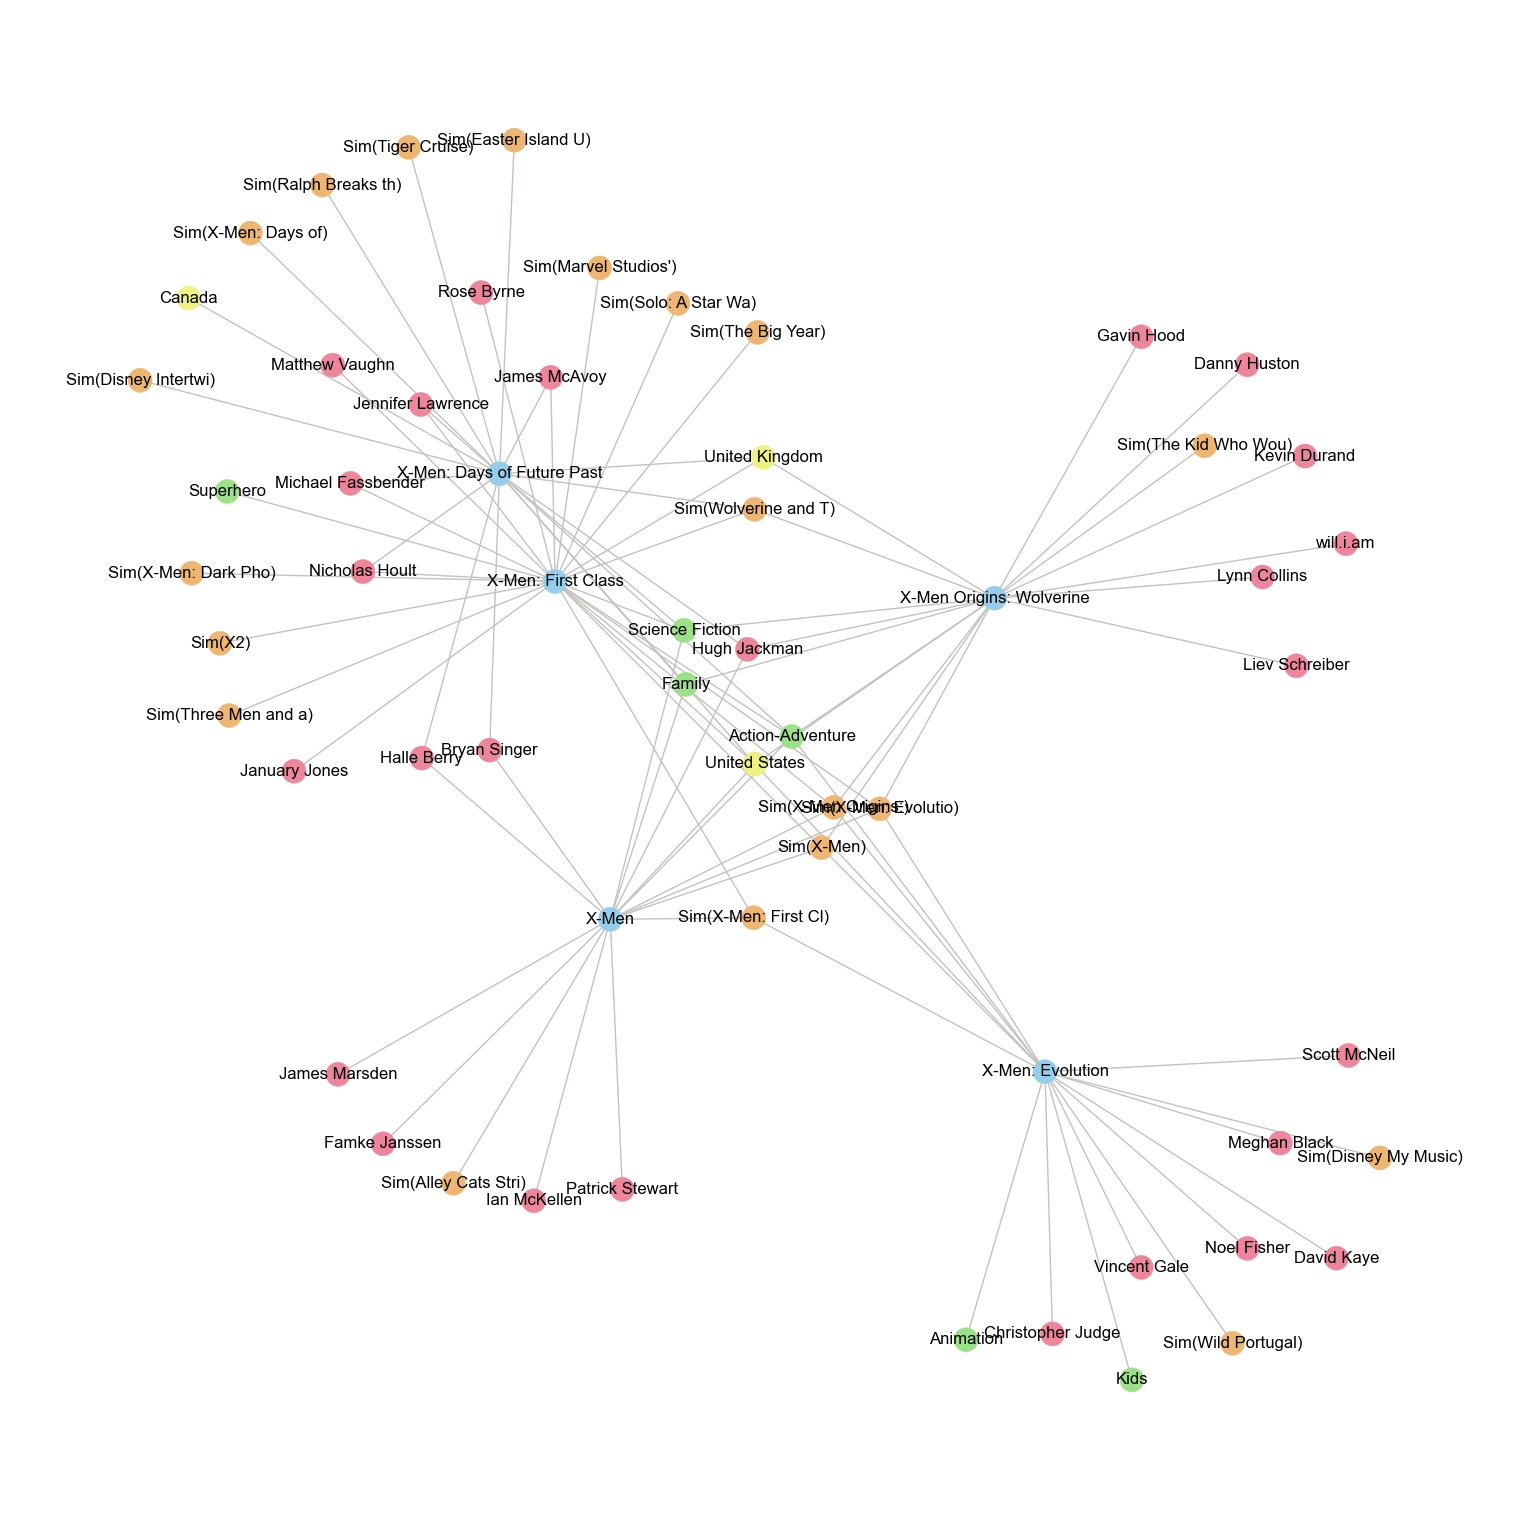

In [10]:
recommend("X-Men Origins: Wolverine")